# Nonparametric estimatio of Doppler function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import sympy as sp

sns.set_context('notebook')
%matplotlib inline

# Doppler function

$$r\left(x\right)=\sqrt{x\left(1-x\right)}\sin\left(\frac{1.2\pi}{x+.05}\right),\quad x\in\left[0,1\right]$$

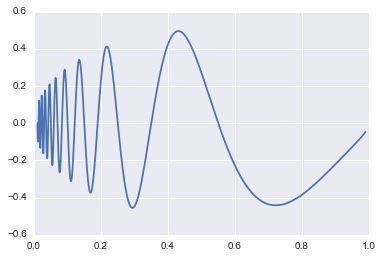

In [2]:
x = np.linspace(.01, .99, num=1e3)
doppler = lambda x : np.sqrt(x * (1 - x)) * np.sin(1.2 * np.pi / (x + .05))

plt.plot(x, doppler(x))
plt.show()

# Derivative of Doppler function

<IPython.core.display.Math object>

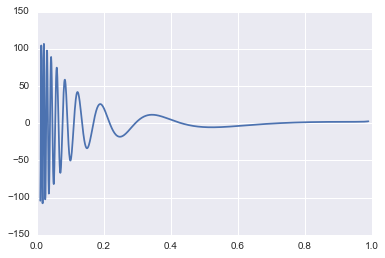

In [3]:
from sympy.utilities.lambdify import lambdify
from IPython.display import display, Math, Latex

u = sp.Symbol('u')

sym_doppler = lambda x : (x * (1 - x))**.5 * sp.sin(1.2 * sp.pi / (x + .05))
d_doppler = sym_doppler(u).diff()
dd_doppler = sym_doppler(u).diff(n=2)

display(Math(sp.latex(d_doppler)))

d_doppler = np.vectorize(lambdify(u, d_doppler))
dd_doppler = np.vectorize(lambdify(u, dd_doppler))

plt.plot(x, d_doppler(x))
plt.show()

# Left and right truncated exponentials

Right truncated:
$$f\left(x\right)=\frac{e^{-x/\lambda}/\lambda}{1-e^{-b/\lambda}},\quad F\left(x\right)=\frac{1-e^{-x/\lambda}}{1-e^{-b/\lambda}},\quad F^{-1}\left(x\right)=-\lambda\log\left(1-x\left(1-e^{-b/\lambda}\right)\right)$$

Left truncated:
$$f\left(x\right)=\frac{e^{x/\lambda}/\lambda}{e^{b/\lambda}-1},\quad F\left(x\right)=\frac{1-e^{x/\lambda}}{1-e^{b/\lambda}},\quad F^{-1}\left(x\right)=\lambda\log\left(1-x\left(1-e^{b/\lambda}\right)\right)$$

In [4]:
def f_rtexp(x, lmbd=1, b=1):
    return np.exp(-x / lmbd) / lmbd / (1 - np.exp(-b / lmbd))

def f_ltexp(x, lmbd=1, b=1):
    return np.exp(x / lmbd) / lmbd / (np.exp(b / lmbd) - 1)

def right_trunc_exp(lmbd=1, b=1, size=1000):
    X = np.sort(np.random.rand(size))
    return - lmbd * np.log(1 - X * (1 - np.exp(-b / lmbd)))

def left_trunc_exp(lmbd=1, b=1, size=1000):
    X = np.sort(np.random.rand(size))
    return lmbd * np.log(1 - X * (1 - np.exp(b / lmbd)))

# Equivalent using SciPy:
# Y = ss.truncexpon.rvs(1, size=1000)

lmbd = .2

Y1 = right_trunc_exp(lmbd=lmbd)
Y2 = left_trunc_exp(lmbd=lmbd)
density1 = ss.gaussian_kde(Y1)
density2 = ss.gaussian_kde(Y2)

U = np.linspace(0, 1, num=1e3)

## Draw the densitites

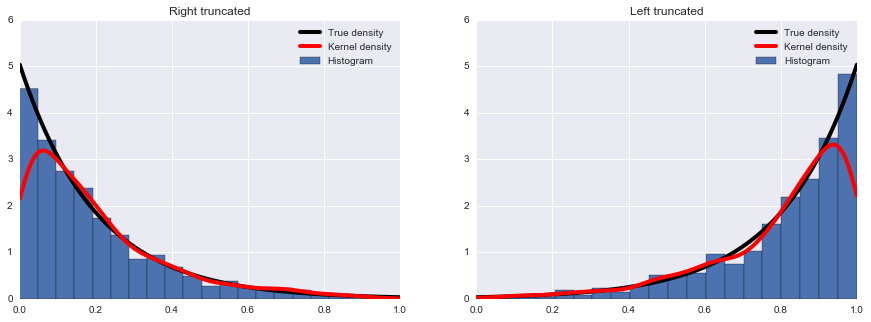

In [5]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(Y1, normed=True, bins=20, label='Histogram')
plt.plot(U, f_rtexp(U, lmbd=lmbd), lw=4, color=[0, 0, 0], label='True density')
plt.plot(U, density1(U), lw=4, color='red', label='Kernel density')
plt.legend()
plt.title('Right truncated')

plt.subplot(1, 2, 2)
plt.hist(Y2, normed=True, bins=20, label='Histogram')
plt.plot(U, f_ltexp(U, lmbd=lmbd), lw=4, color=[0, 0, 0], label='True density')
plt.plot(U, density2(U), lw=4, color='red', label='Kernel density')
plt.legend()
plt.title('Left truncated')

plt.show()

# Kernels

Truncated (Uniform): $k_{0}\left(u\right)=\frac{1}{2}1\left(\left|u\right|\leq1\right)$

Epanechnikov: $k_{1}\left(u\right)=\frac{3}{4}\left(1-u^{2}\right)1\left(\left|u\right|\leq1\right)$

Biweight: $k_{2}\left(u\right)=\frac{15}{16}\left(1-u^{2}\right)^{2}1\left(\left|u\right|\leq1\right)$

Triweight: $k_{2}\left(u\right)=\frac{35}{36}\left(1-u^{2}\right)^{3}1\left(\left|u\right|\leq1\right)$

Gaussian: $k_{\phi}\left(u\right)=\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}u^2\right)$

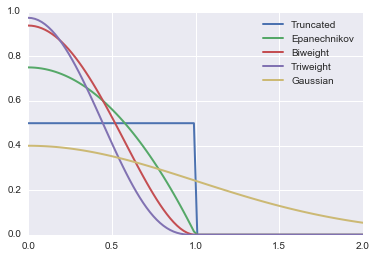

In [6]:
def indicator(x):
    return np.asfarray((np.abs(x) <= 1.) & (np.abs(x) >= 0.))

def kernel(x, ktype='Truncated'):
    if ktype == 'Truncated':
        return .5 * indicator(x)
    if ktype == 'Epanechnikov':
        return 3./4. * (1 - x**2) * indicator(x)
    if ktype == 'Biweight':
        return 15./16. * (1 - x**2)**2 * indicator(x)
    if ktype == 'Triweight':
        return 35./36. * (1 - x**2)**3 * indicator(x)
    if ktype == 'Gaussian':
        return 1./np.sqrt(2. * np.pi) * np.exp(- .5 * x**2)

def roughness(ktype='Truncated'):
    if ktype == 'Truncated':
        return 1./2.
    if ktype == 'Epanechnikov':
        return 3./5.
    if ktype == 'Biweight':
        return 5./7.
    if ktype == 'Triweight':
        return 350./429.
    if ktype == 'Gaussian':
        return np.pi**(-.5)/2.

def sigmak(ktype='Truncated'):
    if ktype == 'Truncated':
        return 1./3.
    if ktype == 'Epanechnikov':
        return 1./5.
    if ktype == 'Biweight':
        return 1./7.
    if ktype == 'Triweight':
        return 1./9.
    if ktype == 'Gaussian':
        return 1.

x = np.linspace(0., 2., 100)

names = ['Truncated', 'Epanechnikov', 'Biweight', 'Triweight', 'Gaussian']

for name in names:
    plt.plot(x, kernel(x, ktype=name), label=name, lw=2)
plt.legend()
plt.show()

# Nadaraya-Watson (NW) or local constant estimator

## Local weighting

For each observed data $X$ ($N$-vector) and grid $U$ ($M$-vector) this function returns $N\times M$-matrix of weights

In [7]:
def weight(U, X, h=.1, ktype='Truncated'):
    # X - N-array
    # U - M-array
    
    # XmU - M*N-array
    XmU = (X - np.atleast_2d(U).T) / h
    # K - M*N-array
    K = kernel(XmU, ktype)
    
    # K.sum(1) - M-array
    # K.T - N*M-array
    # K.T / K.sum(1) - N*M-array
    return  (K.T / K.sum(1)).T

## Nadaraya-Watson (NW)

$$\hat{m}\left(x\right)=\frac{\sum_{i=1}^{n}k\left(\frac{X_{i}-x}{h}\right)Y_{i}}{\sum_{i=1}^{n}k\left(\frac{X_{i}-x}{h}\right)}$$

In [8]:
def NW(U, X, Y, h=.1, ktype='Truncated'):
    return np.dot(weight(U, X, h, ktype), Y)

## Generate data

$$Y_{i}=m\left(X_{i}\right)+\epsilon_{i},\quad\epsilon_{i}\sim NID\left(0,\sigma=0.1\right)$$

In [9]:
def generate_data(N=1000, M=500, lmbd=1, trunc='left'):
    
    if trunc == 'left':
        X = left_trunc_exp(lmbd=lmbd, size=N)
    if trunc == 'right':
        X = right_trunc_exp(lmbd=lmbd, size=N)
    
    e = np.random.normal(0, .1, N) 
    Y = doppler(X) + e
    U = np.linspace(.01, .99, M)
    return X, Y, U

## Perform estimation and plot the results

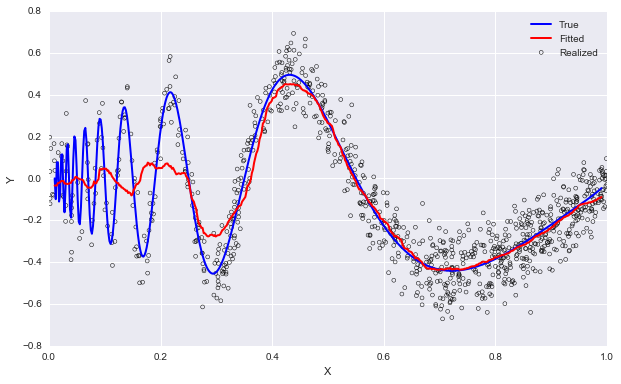

In [10]:
X, Y, U = generate_data()

# Nadaraya-Watson estimator
Yhat = NW(U, X, Y, h=.05, ktype='Truncated')

fig = plt.figure(figsize=(10, 6))
plt.plot(U, doppler(U), lw=2, color='blue', label='True')
plt.plot(U, Yhat, lw=2, color='red', label='Fitted')
plt.scatter(X, Y, s=15, lw=.5, facecolor='none', label='Realized')
plt.xlim([0, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## Bias correction

For bias computation we take the density of $X$ and two derivatives of conditional mean $m(x)$ as known. In practice, they have to be estimated.

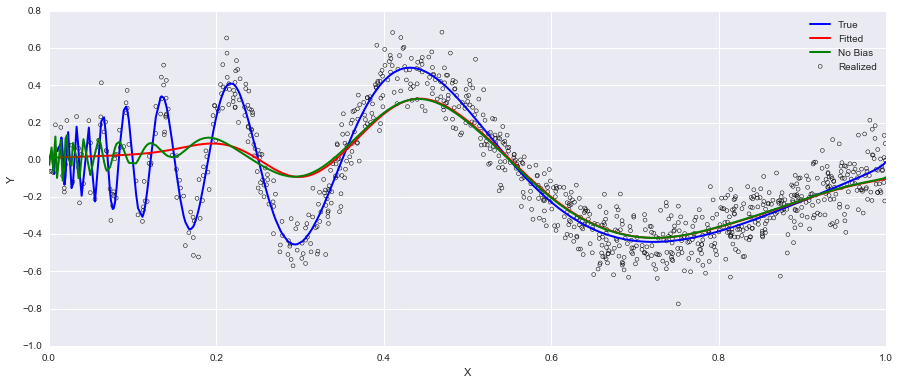

In [11]:
def fx(x, lmbd=1, b=1):
    return sp.exp(-x / lmbd) / lmbd / (1 - sp.exp(-b / lmbd))

dfx = fx(u).diff()
fx = np.vectorize(lambdify(u, fx(u)))
dfx = np.vectorize(lambdify(u, dfx))

def bias(U, etype='NW', h=.05, ktype='Gaussian'):
    if etype == 'NW':
        bias = .5 * dd_doppler(U) + d_doppler(U) * dfx(U) / fx(U)
    if etype == 'LL':
        bias = .5 * dd_doppler(U) * fx(U)
    return bias * h**2 * sigmak(ktype)

h = .05
ktype = 'Gaussian'
fig = plt.figure(figsize=(15, 6))

X, Y, U = generate_data()
Yhat = NW(X, X, Y, h=h, ktype=ktype)
Ynobias = Yhat - bias(X, etype='NW', h=h, ktype=ktype)

plt.plot(X, doppler(X), lw=2, color='blue', label='True')
plt.plot(X, Yhat, lw=2, color='red', label='Fitted')
plt.scatter(X, Y, s=15, lw=.5, facecolor='none', label='Realized')
plt.plot(X, Ynobias, lw=2, color='green', label='No Bias')
plt.xlim([0, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Local Linear (LL) estimator

$$\left(\begin{array}{c}
\hat{\alpha}\left(x\right)\\
\hat{\beta}\left(x\right)
\end{array}\right)=\left(\sum_{i=1}^{n}k_{i}\left(x\right)Z_{i}\left(x\right)Z_{i}\left(x\right)^{\prime}\right)^{-1}\sum_{i=1}^{n}k_{i}\left(x\right)Z_{i}\left(x\right)Y_{i}$$

$$\left(\begin{array}{c}
\hat{\alpha}\left(x\right)\\
\hat{\beta}\left(x\right)
\end{array}\right)
=\left(Z\left(x\right)^{\prime}K\left(x\right)Z\left(x\right)\right)^{-1}Z\left(x\right)^{\prime}K\left(x\right)Y$$

$K(x)$ - $N\times N$

$Z(x)$ - $N\times 2$

$Y$ - $N\times 1$

In [12]:
def LL(U, X, Y, h=.1, ktype='Truncated'):
    # X - N-array
    # U - M-array
    
    # K - M*N-array
    W = weight(U, X, h, ktype)
    alpha = np.empty(U.shape[0])
    beta = np.empty(U.shape[0])
    
    for i in range(U.shape[0]):
        # N*N-array
        K = np.diag(W[i])
        # N-array
        Z1 = (X - U[i]) / h
        Z0 = np.ones(Z1.shape)
        # 2*N-array
        Z = np.vstack([Z0, Z1]).T
        
        # 2*2-array
        A = np.dot(Z.T, np.dot(K, Z))
        # 2-array
        B = np.dot(Z.T, np.dot(K, Y))
        # 2-array
        coef = np.dot(np.linalg.inv(A), B)
        
        alpha[i] = coef[0]
        beta[i] = coef[1]
        
    return alpha, beta

## Perform estimation and plot the results

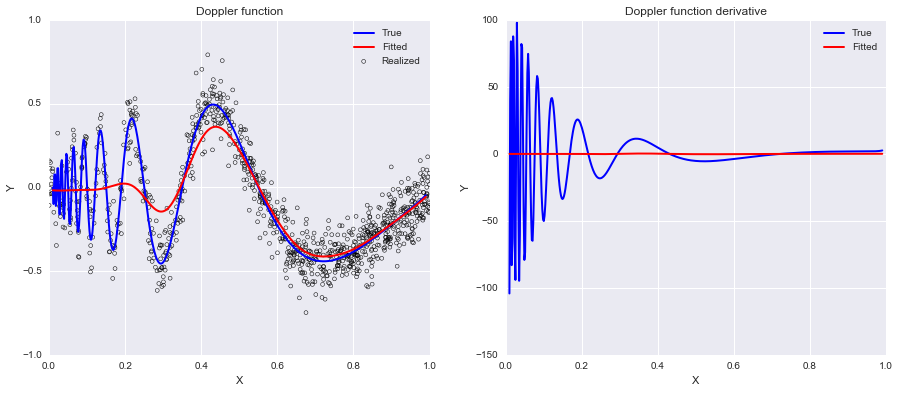

In [13]:
X, Y, U = generate_data()

Yhat, dYhat = LL(U, X, Y, h=.05, ktype='Gaussian')

fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(U, doppler(U), lw=2, color='blue', label='True')
plt.plot(U, Yhat, lw=2, color='red', label='Fitted')
plt.scatter(X, Y, s=15, lw=.5, facecolor='none', label='Realized')
plt.xlim([0, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Doppler function')

plt.subplot(1, 2, 2)
plt.plot(U, d_doppler(U), lw=2, color='blue', label='True')
plt.plot(U, dYhat, lw=2, color='red', label='Fitted')
plt.xlim([0, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Doppler function derivative')

plt.show()

# Comparison for different DGP of X

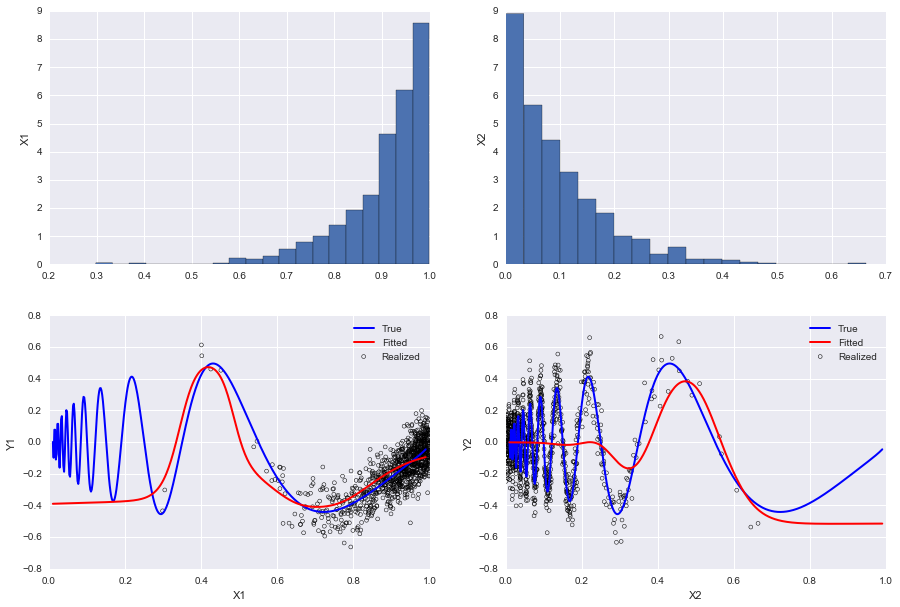

In [14]:
X1, Y1, U = generate_data(lmbd=.1, trunc='left')
X2, Y2, U = generate_data(lmbd=.1, trunc='right')

ktype = 'Gaussian'
h = .05

Y1hat = NW(U, X1, Y1, h=h, ktype=ktype)
Y2hat = NW(U, X2, Y2, h=h, ktype=ktype)

fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(X1, normed=True, bins=20, label='Histogram')
plt.ylabel('X1')

plt.subplot(2, 2, 2)
plt.hist(X2, normed=True, bins=20, label='Histogram')
plt.ylabel('X2')

plt.subplot(2, 2, 3)
plt.plot(U, doppler(U), lw=2, color='blue', label='True')
plt.plot(U, Y1hat, lw=2, color='red', label='Fitted')
plt.scatter(X1, Y1, s=15, lw=.5, facecolor='none', label='Realized')
plt.xlim([0, 1])
plt.xlabel('X1')
plt.ylabel('Y1')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(U, doppler(U), lw=2, color='blue', label='True')
plt.plot(U, Y2hat, lw=2, color='red', label='Fitted')
plt.scatter(X2, Y2, s=15, lw=.5, facecolor='none', label='Realized')
plt.xlim([0, 1])
plt.xlabel('X2')
plt.ylabel('Y2')
plt.legend()

plt.show()

# Conditional variance and confidence intervals

## Leave-one-out errors

In [15]:
def error(Y, X, h, ktype):
    ehat = np.empty(X.shape)

    for i in range(X.shape[0]):
        ehat[i] = Y[i] - NW(X[i], np.delete(X, i), np.delete(Y, i), h=h, ktype=ktype)
    
    return np.array(ehat)

## Estimate variance

In [16]:
N = 500
X, Y, U = generate_data(N=N, lmbd=.2)

h = .05
ktype = 'Epanechnikov'

Yhat = NW(U, X, Y, h=h, ktype=ktype)

ehat = error(Y, X, h, ktype)
sigma2hat = NW(U, X, ehat**2, h=.1, ktype=ktype)
fxhat = ss.gaussian_kde(X)(U)
V2hat = roughness(ktype) * sigma2hat / fxhat / N / h
shat = V2hat**.5

## Plot the results

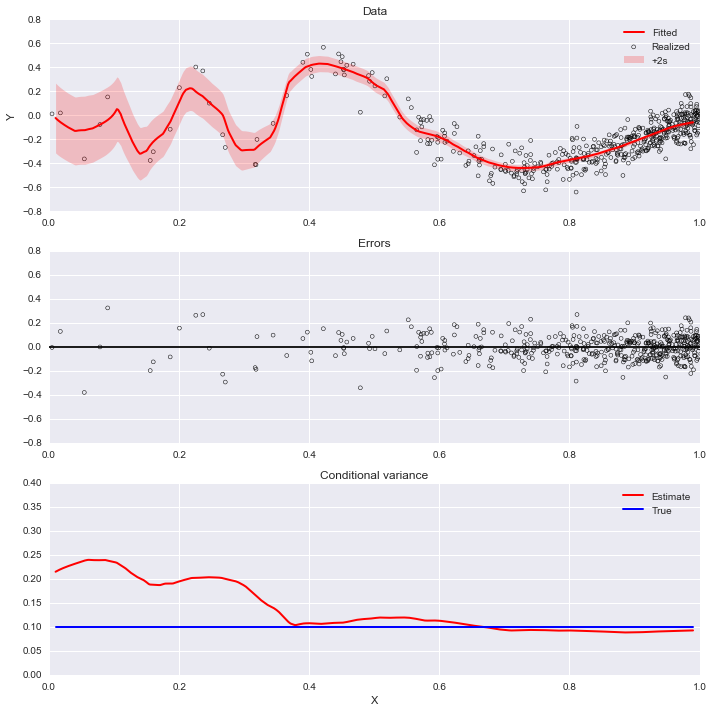

In [17]:
fig = plt.figure(figsize = (10, 10))

plt.subplot(3, 1, 1)
plt.scatter(X, Y, s=15, lw=.5, facecolor='none', label='Realized')
#plt.plot(U, doppler(U), lw=2, color='blue', label='True')
plt.fill_between(U, Yhat - 2*shat, Yhat + 2*shat, lw=0, color='red', alpha=.2, label='+2s')
plt.plot(U, Yhat, lw=2, color='red', label='Fitted')
plt.ylabel('Y')
plt.legend()
plt.xlim([0, 1])
ylim = plt.gca().get_ylim()
plt.title('Data')

plt.subplot(3, 1, 2)
plt.scatter(X, ehat, s=15, lw=.5, facecolor='none', label='Errors')
plt.axhline(color='black')
plt.ylim(ylim)
plt.xlim([0, 1])
plt.title('Errors')

plt.subplot(3, 1, 3)
plt.plot(U, sigma2hat**.5, lw=2, color='red', label='Estimate')
plt.plot(U, .1 * np.ones(U.shape), lw=2, color='blue', label='True')
plt.ylim([0, .4])
plt.xlim([0, 1])
plt.legend()
plt.xlabel('X')
plt.title('Conditional variance')

plt.tight_layout()
plt.show()

# Bandwidth selection

## Cross-validation criterion

$$\tilde{e}_{i}\left(h\right)=Y_{i}-\tilde{m}_{-i}\left(X_{i},h\right)$$

$$CV\left(h\right)=\frac{1}{n}\sum_{i=1}^{n}\tilde{e}_{i}\left(h\right)^{2}$$

$$\hat{h}=\arg\min_{h\geq h_{l}}CV\left(h\right)$$

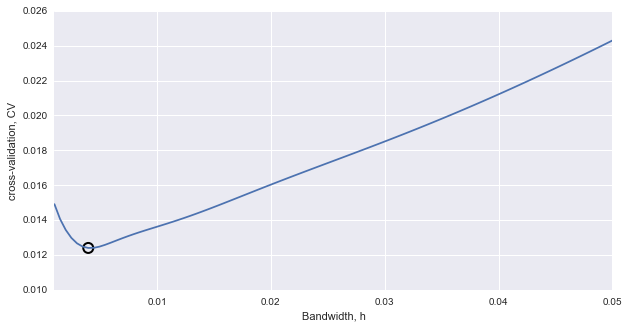

In [18]:
N = 500
X, Y, U = generate_data(N=N)

ktype = 'Gaussian'

H = np.linspace(.001, .05, 100)
CV = np.array([])
for h in H:
    ehat = error(Y, X, h, ktype)
    CV = np.append(CV, np.mean(ehat**2))

h = H[CV.argmin()]
Yhat = NW(U, X, Y, h=h, ktype=ktype)

ehat = error(Y, X, h, ktype)
sigma2hat = NW(U, X, ehat ** 2, h=h, ktype=ktype)
fxhat = ss.gaussian_kde(X)(U)
V2hat = roughness(ktype) * sigma2hat / fxhat / N / h
shat = V2hat**.5

plt.figure(figsize=(10, 5))
plt.plot(H, CV)
plt.scatter(h, CV.min(), facecolor='none', lw=2, s=100)
plt.xlim([H.min(), H.max()])
plt.xlabel('Bandwidth, h')
plt.ylabel('cross-validation, CV')
plt.show()

## Plot the (optimized) fit

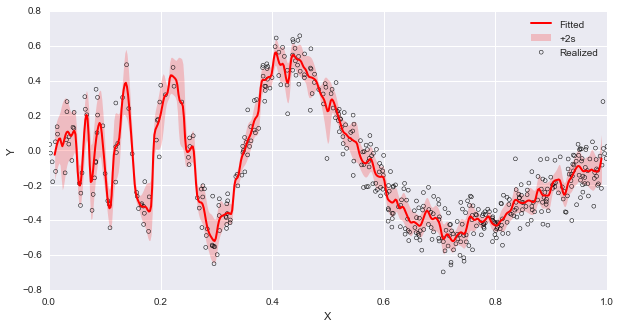

In [19]:
plt.figure(figsize=(10, 5))
#plt.plot(U, doppler(U), lw=2, color='blue', label='True')
plt.fill_between(U, Yhat - 2*shat, Yhat + 2*shat, lw=0, color='red', alpha=.2, label='+2s')
plt.plot(U, Yhat, lw=2, color='red', label='Fitted')
plt.scatter(X, Y, s=15, lw=.5, facecolor='none', label='Realized')
plt.xlim([0, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()